# Fitting Gaussian Process Models in Python

### Chris Fonnesbeck

A common applied statistics task involves building regression models to characterize non-linear relationships between variables. It is possible to fit such models by assuming a particular non-linear structure, such as a sinusoidal, exponential, or polynomial function, to describe a given response by one variable to another. Unless this relationship is obvious from the outset, however, it involves possibly extensive model selection procedures to ensure the most appropriate model is retained. Alternatively, a non-parametric approach can be adopted by defining a set of knots across the variable space and use a spline or kernel regression to describe arbitrary non-linear relationships. However, knot layout procedures are somewhat *ad hoc* and can also involve variable selection. A third alternative is to adopt a **Bayesian non-parametric** strategy, and directly model the unknown underlying function. For this, we can employ Gaussian process models.

Use of the term "non-parametric" in the context of Bayesian analysis is something of a misnomer. This is because the fundamental first step in Bayesian modeling is to specify a *full probability model* for the problem at hand, assigning probability densities to all unknown quantities of interest. So, it is difficult to explicitly state a full probability model without the use of probability functions, which are parametric! It turns out that Bayesian non-parametric methods do not imply that there are no parameters, but rather that the number of parameters grows with the size of the dataset. In fact, Bayesian non-parametric models are *infinitely* parametric.

## Building models with Gaussians

What if we chose to use Gaussian distributions to model our data? 

$$p(x \mid \pi, \Sigma) = (2\pi)^{-k/2}|\Sigma|^{-1/2} \exp\left\{ -\frac{1}{2} (x-\mu)^{\prime}\Sigma^{-1}(x-\mu) \right\}$$

There would not seem to be an advantage to doing this, because normal distributions are not particularly flexible distributions in and of themselves. However, adopting a set of Gaussians (a multivariate normal vector) confers a number of advantages. First, the marginal distribution of any subset of elements from  a multivariate normal distribution is also normal:

$$p(x,y) = \mathcal{N}\left(\left[{
\begin{array}{c}
  {\mu_x}  \\
  {\mu_y}  \\
\end{array}
}\right], \left[{
\begin{array}{c}
  {\Sigma_x} & {\Sigma_{xy}}  \\
  {\Sigma_{xy}^T} & {\Sigma_y}  \\
\end{array}
}\right]\right)$$

$$p(x) = \int p(x,y) dy = \mathcal{N}(\mu_x, \Sigma_x)$$

Also, conditionals distributions of a subset of a multivariate normal distribution (conditional on the remaining elements) are normal too:

$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), 
\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$$

A Gaussian process generalizes the multivariate normal to infinite dimension. It is defined as an infinite collection of random variables, any finite subset of which have a Gaussian distribution. Thus, the marginalization property is explicit in its definition. Another way of thinking about an infinite vector is as a *function*. When we write a function that takes continuous values as inputs, we are essentially specifying an infinte vector that only returns values (indexed by the inputs) when the function is called upon to do so. By the same token, this notion of an infinite-dimensional Gaussian as a function allows us to work with them computationally: we are never required to store all the elements of the Gaussian process, only to calculate them on demand.

So, we can describe a Gaussian process as a ***disribution over functions***. Just as a multivariate normal distribution is completely specified by a mean vector and covariance matrix, a GP is fully specified by a mean *function* and a covariance *function*:

$$p(x) \sim \mathcal{GP}(m(x), k(x,x^{\prime}))$$

It is the marginalization property that makes working with a Gaussian process feasible: we can marginalize over the infinitely-many variables that we are not interested in, or have not observed. 

For example, one specification of a GP might be as follows:

$$\begin{aligned}
m(x) &=0 \\
k(x,x^{\prime}) &= \theta_1\exp\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right)
\end{aligned}$$

here, the covariance function is a **squared exponential**, for which values of $x$ and $x^{\prime}$ that are close together result in values of $k$ closer to 1 and those that are far apart return values closer to zero. It may seem odd to simply adopt the zero function to represent the mean function of the Gaussian process -- surely we can do better than that! It turns out that most of the learning in the GP involves the covariance function and its parameters, so very little is gained in specifying a complicated mean function.

For a finite number of points, the GP becomes a multivariate normal, with the mean and covariance as the mean functon and covariance function evaluated at those points.

## Sampling from a Gaussian Process

To make this notion of a "distribution over functions" more concrete, let's quickly demonstrate how we obtain realizations from a Gaussian process, which result in an evaluation of a function over a set of points. All we will do here is sample from the *prior* Gaussian process, so before any data have been introduced. What we need first is our covariance function, which will be the squared exponential, and a function to evaluate the covariance at given points (resulting in a covariance matrix).

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pylab as plt

np.random.seed(42)

def exponential_cov(x, y, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(x, y)**2)

We are going generate realizations sequentially, point by point, using the lovely conditioning property of mutlivariate Gaussian distributions. Here is that conditional:

$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), 
\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$$

And this the function that implements it:

In [2]:
def conditional(x_new, x, y, params):
    B = exponential_cov(x_new, x, params)
    C = exponential_cov(x, x, params)
    A = exponential_cov(x_new, x_new, params)
    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
    return(mu.squeeze(), sigma.squeeze())

We will start with a Gaussian process prior with hyperparameters $\theta_0=1, \theta_1=10$. We will also assume a zero function as the mean, so we can plot a band that represents one standard deviation from the mean.

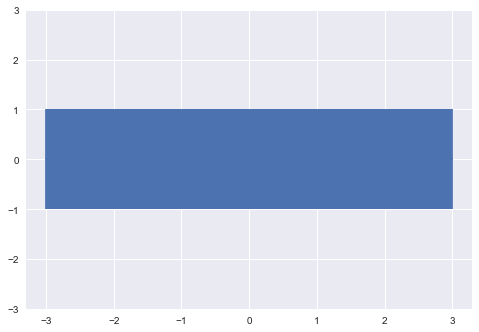

In [3]:
θ = [1, 10]
σ_0 = exponential_cov(0, 0, θ)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=σ_0, capsize=0)
plt.ylim(-3, 3);

Let's select an arbitrary starting point to sample, say $x=1$. Since there are no prevous points, we can sample from an unconditional Gaussian:

In [4]:
x = [1.]
y = [np.random.normal(scale=σ_0)]
y

[0.4967141530112327]

We can now update our confidence band, given the point that we just sampled, using the covariance function to generate new point-wise intervals, conditional on the value $[x_0, y_0]$. 

In [5]:
σ_1 = exponential_cov(x, x, θ)

In [6]:
def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

In [7]:
x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, θ, σ_1, y) for i in x_pred]

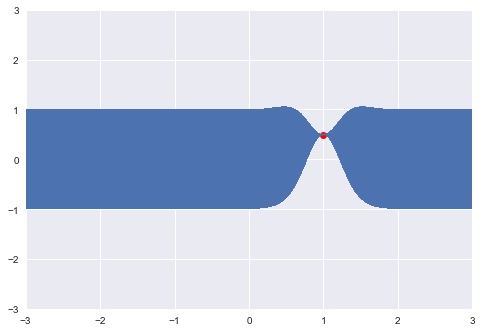

In [8]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.xlim(-3, 3); plt.ylim(-3, 3);

So conditional on this point, and the covariance structure we have specified, we have essentially constrained the probable location of additional points. Let's now sample another:

In [9]:
m, s = conditional([-0.7], x, y, θ)
y2 = np.random.normal(m, s)
y2

-0.1382640378102619

This point is added to the realization, and can be used to further update the location of the next point.

In [10]:
x.append(-0.7)
y.append(y2)

In [11]:
σ_2 = exponential_cov(x, x, θ)

predictions = [predict(i, x, exponential_cov, θ, σ_2, y) for i in x_pred]

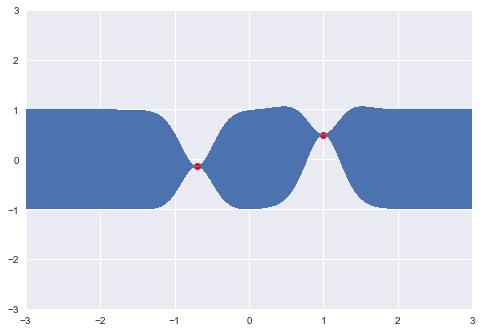

In [12]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.xlim(-3, 3); plt.ylim(-3, 3);

Of course, sampling sequentially is just a heuristic to demonstrate how the covariance structure works. We can just as easily sample several points at once:

In [13]:
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, θ)
y_more = np.random.multivariate_normal(mu, s)
y_more

array([-1.5128756 ,  0.52371713, -0.13952425, -0.93665367, -1.29343995])

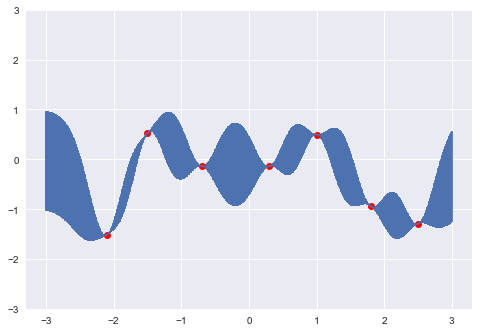

In [14]:
x += x_more
y += y_more.tolist()

σ_new = exponential_cov(x, x, θ)

predictions = [predict(i, x, exponential_cov, θ, σ_new, y) for i in x_pred]

y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.ylim(-3, 3);

So as the density of points becomes high, the result will be one realization (function) from the prior GP. 

# Fitting Gaussian Processes in Python

Though it's entirely possible to extend the code above to introduce data and fit a Gaussian processes by hand, there are a number of libraries available for specifying and fitting GP models in a more automated way. I will demonstrate and compare three packages that include classes and functions specifically tailored for GP modeling:

- [scikit-learn](http://scikit-learn.org/stable/modules/gaussian_process.html)
- [GPflow](http://gpflow.readthedocs.io/en/latest/intro.html)
- [PyMC3](https://pymc-devs.github.io/pymc3/)

In particular, each of these packages include covariance functions that can be flexibly combined to adequately describe the patterns of non-linearity in the data, along with methods for fitting the parameters of the GP.

We will use some simulated data as a test case for comparing the performance of each package. I don't actually recall where I found this data, so I have no details regarding how it was generated . However, it clearly shows some type of non-linear process, corrupted by a certain amount of observation or measurement error so it should be a reasonable task for a Gaussian process approach.

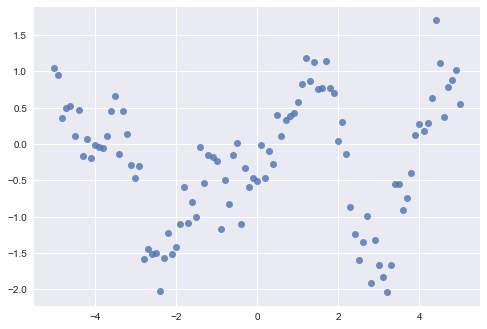

In [15]:
%run get_data.py
sns.regplot(x, y, fit_reg=False)

## scikit-learn

`scikit-learn` is the premier machine learning package for Python. It provides a comprehensive set of supervised and unsupervised learning algortihms, implemented under a consistent API that makes your entire modeling pipeline (from data preparation through output summarization) as frictionless as possible. Included among its library of tools is a Gaussian process module, which recently underwent a complete revision (as of version 0.18). 

Consistent with the implementation of other machine learning methods in `scikit-learn`, the appropriate interface for using GPs depends on the type of task to which it is being applied. For regression tasks, where we are predicting a continuous response variable, a `GaussianProcessRegressor` is applied by specifying an appropriate covariance function, or **kernel**. Fitting proceeds by maximizing the log of the marginal likelihood, a convenient approach for Gaussian processes that avoids the computationally-intensive crossvalidation strategy that is usually employed in choosing optimial hyperparameters for the model. The `GaussianProcessRegressor` does not allow for the specification of the mean function, always assuming it to be the zero function, highlighting the diminished role of the mean function in calculating the posterior.

For classification tasks, where the output variable is categorical (or binary), the `GaussianProcessClassifier` is used. This may seem incongruous, using normal distributions to fit categorical data, but is accomodated by using a latent Gaussian response variable and then transforming it to the unit interval (or more generally for more than two outcome classes, a simplex). The result of this is a soft, probabilistic classification rather than a hard classification that is common in machine learning algorithms. Similar to the regression setting, the user chooses an appropriate kernel to describe the type of covariance expected in the dataset. Since the posterior of this GP is non-normal, a Laplace approximation is used to obtain a solution, rather than maximizing the marginal likelihood. 

In [16]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

`scikit-learn` offers a library of about a dozen covariance functions, which they call *kernels*, to choose from. A flexible choice to start with is the Mat&#232;rn covariance. 

$$k_{M}(x) = \frac{\sigma^2}{\Gamma(\nu)2^{\nu-1}} \left(\frac{\sqrt{2 \nu} x}{l}\right)^{\nu} K_{\nu}\left(\frac{\sqrt{2 \nu} x}{l}\right)$$

where where $\Gamma$ is the gamma function and $K$ is a modified Bessel function. The form of covariance matrices sampled from this function is governed by three parameters, each of which controls a property of the covariance.

* **amplitude** ($\sigma$) controls the scaling of the output along the y-axis. This parameter is just a scalar multiplier, and is therefore usually left out of implementations of the Mat&#232;rn function (*i.e.* set to one)

* **lengthscale** ($l$) complements the amplitude by scaling realizations on the x-axis. Larger values make points appear closer together.

* **roughness** ($\nu$) controls the sharpness of ridges in the covariance function, which ultimately affect the roughness (smoothness) of realizations.

Though in general all the parameters are non-negative real-valued, when $\nu = p + 1/2$ for integer-valued $p$, the function can be expressed partly as a polynomial function of order $p$ and generates realizations that are $p$-times differentiable, so values $\nu \in \{3/2, 5/2\}$ are extremely common.

A GP kernel can be specified as the sum of additive components in `scikit-learn` simply by using the sum operator, so we can include a Mat&#232;rn component (`Matern`), an amplitude factor (`ConstantKernel`), as well as an observation noise (`WhiteKernel`):

In [17]:
kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)

As mentioned, the `scikit-learn` API is very consistent across learning methods, and as a result, all functions expect a tabular set of input variables, either as a 2-dimensional NumPy `array` or a pandas `DataFrame`. Since we have only a single input variable here, we can add a second dimension using the `reshape` method:

In [18]:
X = x.reshape(-1, 1)
X.shape

(101, 1)

Finally, we instantiate a `GaussianProcessRegressor` object with our custom kernel, and call its `fit` method, passing the input (`X`) and output (`y`) arrays.

In [19]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

Conveniently, `scikit-learn` displays the configuration that is used for the fitting algorithm each time one of its classes is instantiated. This is useful because it reveals hidden settings that are given default values if not specified by the user; these settings can often influence the resulting fit, so its important that we understand what `fit` has assumed on our behalf. Here, for example, we see that the L-BFGS-B algorithm has been used to optimized the hyperparameters (`optimizer='fmin_l_bfgs_b'`) and that the output variable has not been normalized (`normalize_y=False`). When there is a fear of finding a local, rather than a global, maximum in the marginal likelihood, a non-zero value can be specified for `n_restarts_optimizer`, which will run the optimization algorithm as many times as specified, using randomly-chosen starting coordinates, in the hope that a globally-competitive value can be discovered.

The `fit` method endows the returned model object with attributes associated with the fitting procedure; these attributes will all have an underscore (`_`) appended to their names. For example, the `kernel_` attribute will return the kernel used to parameterize the GP, along with their corresponding optimal hyperparameter values:

In [20]:
gp.kernel_

0.00316**2 + Matern(length_scale=1.11, nu=1.5) + WhiteKernel(noise_level=0.0912)

Along with the `fit` method, each supervised learning class retains a `predict` method that generates predicted outcomes ($y^*$) given a new set of predictors ($X^*$) distinct from those used to fit the model. For a Gaussian process, this is fulfulled by the *posterior predictive distribution*, which is the Gaussian process with the mean and covariance functions updated to their posterior forms, after having been fit. 

$$p(y^*|y, x, x^*) = \mathcal{GP}(m^*(x^*), k^*(x^*))$$

where the posterior mean and covariance functions are calculated as:

$$\begin{aligned}
m^*(x^*) &= k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}y \\
k^*(x^*) &= k(x^*,x^*)+\sigma^2 - k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}k(x^*,x)
\end{aligned}$$

In [21]:
x_pred = np.linspace(-6, 6).reshape(-1,1)
y_pred, sigma = gp.predict(x_pred, return_std=True)

Notice that we can calculate a prediction for arbitrary inputs $X^*$. To get a sense of the form of the posterior over a range of likely inputs, we can pass it a linear space as we have done above. `predict` optionally returns posterior standard deviations along with the expected value, so we can use this to plot a confidence region around the expected function:

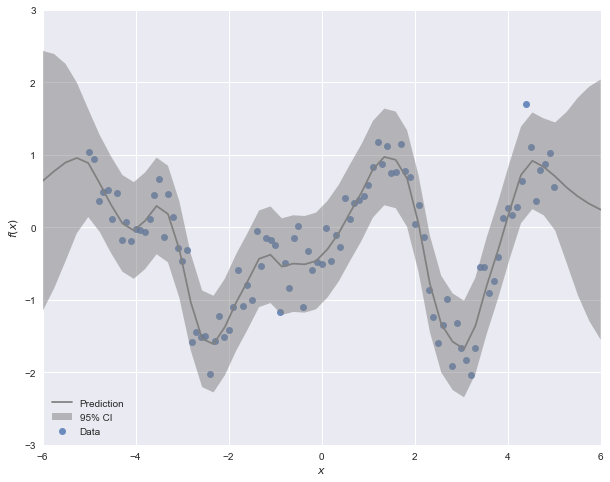

In [22]:
plt.figure(figsize=(10,8))
sns.regplot(x, y, fit_reg=False, label='Data')
plt.plot(x_pred, y_pred, color='grey', label='Prediction')
plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([y_pred - 2*sigma,
                        (y_pred + 2*sigma)[::-1]]),
         alpha=.5, fc='grey', ec='None', label='95% CI')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim(-6, 6)
plt.ylim(-3, 3)
plt.legend(loc='lower left');

## GPflow

One of the early projects to provide a standalone package for fitting Gaussian processes in Python was [GPy](http://sheffieldml.github.io/GPy/) by the Sheffield machine learning group. Much like `scikit-learn`'s `gaussian_process` module, GPy provides a set of classes for specifying and fitting Gaussian processes, with a large library of kernels that can be combined as needed. GPflow is a re-implementation of the GPy library, using Google's popular [TensorFlow](https://www.tensorflow.org) library as its computational backend. The main advantage of this change for most users is that it allows the use of more modern methods for fitting larger GP models, namely variational inference and Markov chain Monte Carlo.

Let's demonstrate GPflow usage by fitting our simulated dataset. The API is slightly more general than `scikit-learns`, as it expects tabular inputs for both the predictors (features) and outcomes. Hence, we must reshape `y` to a tabular format:

In [23]:
Y = y.reshape(-1,1)

To mirror the `scikit-learn` model, we will again specify a Matèrn covariance function. GPflow has two user-facing subclasses, one which fixes the roughness parameter to 3/2 (`Matern32`) and another to 5/2 (`Matern52`). Amplitude is an included parameter (`variance`), so we do not need to include a separate constant kernel. 

In [24]:
import GPflow

k = GPflow.kernels.Matern32(1, variance=1, lengthscales=1.2) 

There are six different GP classes, chosen according to the covariance structure (full vs. sparse approximation) and the likelihood of the model (Gaussian vs. non-Gaussian). The main innovation of GPflow is that non-conjugate models (*i.e.* those with a non-normal likelihood) can be fit either using Markov chain Monte Carlo or an approximation via variational inference.

Since our model involves a straightforward conjugate Gaussian likelihood, we can use the `GPR` (Gaussian process regression) class. 

In [25]:
m = GPflow.gpr.GPR(X, Y, kern=k)

We can access the parameter values simply by printing the regression model object.

In [26]:
print(m)

model.kern.variance transform:+ve prior:None
[ 1.]
model.kern.lengthscales transform:+ve prior:None
[ 1.2]

model.likelihood.variance transform:+ve prior:None
[ 1.]


Notice that, in addition to the hyperparameters of the Matèrn kernel, there is an additional variance parameter that is associated with the normal likelihood. We can set it to non-default values by direct assignment.

In [27]:
m.likelihood.variance = 0.01

This model is fit using the `optimize` method, which runs a gradient ascent algorithm on the model likelhiood (it uses the `minimize` function from SciPy as a default optimizer).

In [28]:
m.optimize()

      fun: 54.247759719230586
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -2.77533984e-06,   2.90014513e-06,   3.09872057e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 16
      nit: 15
   status: 0
  success: True
        x: array([ 0.3208171,  0.6063578, -2.3496958])

In [29]:
m

Name,values,prior,constraint
model.kern.variance,[ 0.86636739],None,+ve
model.kern.lengthscales,[ 1.04159852],None,+ve
model.likelihood.variance,[ 0.09111893],None,+ve


The model object includes a `predict_y` attribute, which we can use to obtain expected values and variances on an arbitrary grid of input values.

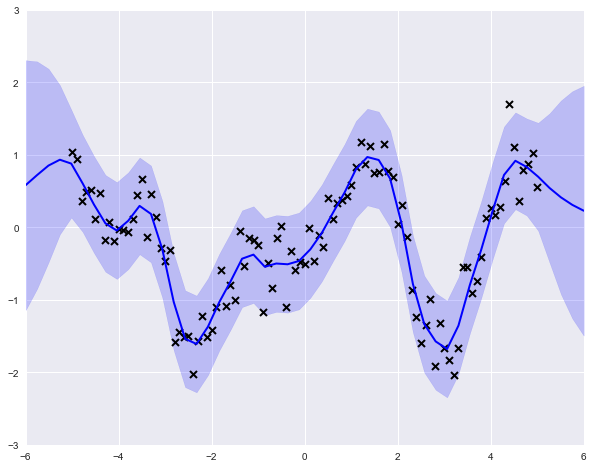

In [30]:
plt.figure(figsize=(10,8))
xx = np.linspace(-6, 6).reshape(-1,1)

def plot(m):
    mean, var = m.predict_y(xx)
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'b', lw=2)
    plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
    plt.xlim(-6, 6)
    plt.ylim(-3, 3)
plot(m)

You might have noticed that there is nothing particularly Bayesian about what we have done here. No priors have been specified, and we have just performed maximum likelihood to obtain a solution.

In [31]:
m.kern.variance.prior = GPflow.priors.Gamma(1,0.1)
m.kern.lengthscales.prior = GPflow.priors.Gamma(1,0.1)

In addition to specifying priors on the hyperparameters, we can also fix values if we have information to justify doing so. For example, we may know the measurement error of our data-collecting instrument, so we can assign that error value as a constant.

In [32]:
m.likelihood.variance = 0.1
m.likelihood.variance.fixed = True

In [33]:
m.optimize()

      fun: 63.930638821013005
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -3.35442332e-06,   8.13287362e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 6
   status: 0
  success: True
        x: array([-0.75649791, -0.16326004])

Though we may feel satisfied that we have a proper Bayesian model, the end result is very much the same. All we have done is added the log-probabilities of the priors to the model, and performed optimization again. This time, the result is a maximum *a posteriori* (MAP) estimate.

In [34]:
print(m)

model.kern.variance transform:+ve prior:Ga([ 1.],[ 0.1])
[ 0.38479193]
model.kern.lengthscales transform:+ve prior:Ga([ 1.],[ 0.1])
[ 0.6148462]

model.likelihood.variance transform:+ve prior:None [FIXED]
[ 0.1]


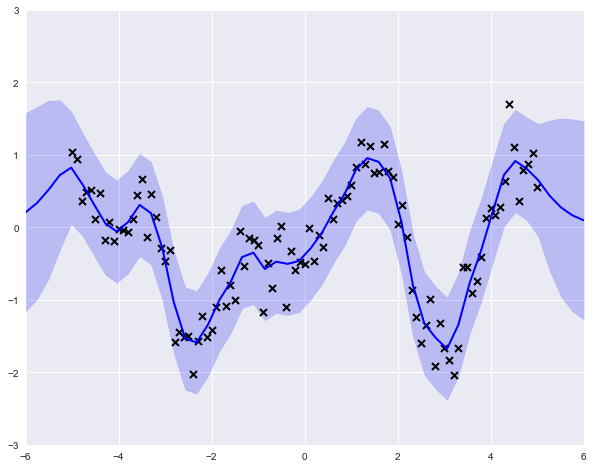

In [35]:
plt.figure(figsize=(10,8))
def plot(m):
    mean, var = m.predict_y(xx)
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'b', lw=2)
    plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
    plt.xlim(-6, 6)
    plt.ylim(-3, 3)
plot(m)

To perform a "Fully Bayesian" analysis, we can use the more general `GPMC` class, which jointly samples over the parameters and the functions. For this, we need to specify a likelihood as well as priors for the kernel parameters. Let's change the model slightly and use a Student's T likelihood, which will be more robust to the influence of extreme values.

In [36]:
l = GPflow.likelihoods.StudentT()
m = GPflow.gpmc.GPMC(X, Y, kern=k, likelihood=l)

In [37]:
m.kern.variance.prior = GPflow.priors.Gamma(1,1)
m.kern.lengthscales.prior = GPflow.priors.Gamma(1,1)

Rather than `optimize`, we fit the `GPMC` model using the `sample` method. This will employ [Hamiltonian Monte Carlo](https://arxiv.org/pdf/1206.1901.pdf) (HMC), an efficient form of Markov chain Monte Carlo that takes advantage of gradient information to improve posterior sampling. The TensorFlow library provides automatic differentiation functions that allow the gradient to be calculated for arbitrary models. The HMC algorithm requires the specification of hyperparameter values that determine the behavior of the sampling procedure; these parameters can be tuned.

In [38]:
trace = m.sample(1000, verbose=True, epsilon=0.03, Lmax=15)

Iteration:  100 	 Acc Rate:  97.0 %
Iteration:  200 	 Acc Rate:  93.0 %
Iteration:  300 	 Acc Rate:  95.0 %
Iteration:  400 	 Acc Rate:  92.0 %
Iteration:  500 	 Acc Rate:  97.0 %
Iteration:  600 	 Acc Rate:  94.0 %
Iteration:  700 	 Acc Rate:  93.0 %
Iteration:  800 	 Acc Rate:  99.0 %
Iteration:  900 	 Acc Rate:  98.0 %
Iteration:  1000 	 Acc Rate:  96.0 %


We end up with a trace containing sampled values from the kernel parameters, which can be plotted to get an idea about the posterior uncertainty in their values, after being informed by the data.

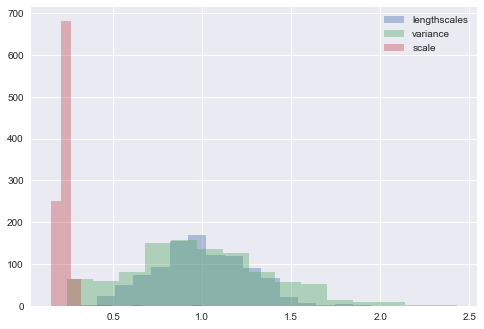

In [39]:
parameter_samples = m.get_samples_df(trace)

for col in parameter_samples.columns.sort_values()[1:]:
    parameter_samples[col].hist(label=col.split('.')[-1], alpha=0.4, bins=15)
    
plt.legend()

We can then go back and generate predictions from the posterior GP, and plot several of them to get an idea of the predicted underlying function.

In [40]:
realizations = []
for sample in trace[-100:]:
    m.set_state(sample)
    realizations.append(m.predict_f_samples(xx, 1).squeeze())
realizations = np.vstack(realizations)

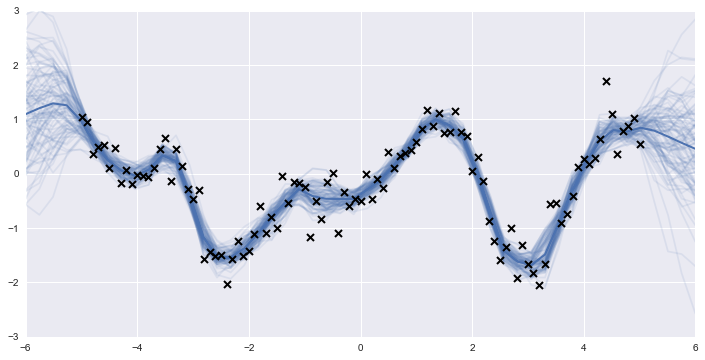

In [41]:
plt.figure(figsize=(12, 6))
line, = plt.plot(xx.squeeze(), np.mean(realizations, 0), lw=2)
for draw in realizations:
    plt.plot(xx.squeeze(), draw, color=line.get_color(), alpha = 0.1)
plt.plot(X, Y, 'kx', mew=2)
plt.xlim(-6, 6)
plt.ylim(-3, 3);

Thus, it may benefit users with models that have unusual likelihood functions or models that are difficult to fit using gradient ascent optimization methods to use GPflow in place of `scikit-learn`. Moreover, if inference regarding the GP hyperparameters are of interest, or if prior information exists that would be useful in obtaining more accurate estimates, then a fully Bayesian approach such as that offered by GPflow's model classes is necessary.

## PyMC3

The PyMC project is a very general Python package for probabilistic programming that can be used to fit nearly any Bayesian model (*disclosure*: I have been a developer of PyMC since its creation). Similarly to GPflow, the current version (PyMC3) has been re-engineered from earlier versions to rely on a modern computational backend. Rather than TensorFlow, PyMC3 is build on top of [Theano](http://deeplearning.net/software/theano/), an engine for evaluating expressions defined in terms of operations on tensors. It works in much the same way as TensorFlow, at least superficially, providing automatic differentiation, parallel computation, and dynamic generation of efficient, compiled code.

In [42]:
import pymc3 as pm
import theano.tensor as tt

PyMC3 is a Bayesian modeling *toolkit*, providing mean functions, covariance functions and probability distributions that can be combined as needed to construct a Gaussian process model. Models are specified by declaring variables and functions of variables to specify a fully-Bayesian model. Declarations are made inside of a `Model` context, which automatically adds them to the model in preparation for fitting. Let's start out by instantiating a model, and adding a Matèrn covariance function and its hyperparameters:

In [49]:
with pm.Model() as gp_fit:

    ρ = pm.Gamma('ρ', 1, 1)
    η = pm.Gamma('η', 1, 1)
    
    K = η * pm.gp.cov.Matern32(1, ρ)

We can continue to build upon our model by speficying a mean function (this is redundant here, since a zero function is assumed when not specified) and an observation noise variable, which we will give a half-Cauchy prior:

In [50]:
with gp_fit:
    
    M = pm.gp.mean.Zero()
    
    σ = pm.HalfCauchy('σ', 2.5)

The Gaussian process model is encapsulated within the `GP` class, parameterized by the mean function, covariance function, and observation error specified above. Since the outcomes of the GP have been observed, we provide that data to the instance of `GP` in the `observed` argument as a dictionary. These are fed to the underlying multivariate normal likelihood.

In [ ]:
with gp_fit:
    
    y_obs = pm.gp.GP('y_obs', mean_func=M, cov_func=K, sigma=σ, observed={'X':X, 'Y':y})

The `sample` function called inside the `Model` context fits the model using MCMC sampling. By default, PyMC3 uses an auto-tuning version of HMC called the [No U-turn Sampler](https://arxiv.org/abs/1111.4246) (NUTS) that picks appropriate values for the path length and step size parameters that we saw in GPflow's `sample` calls. Additionally, to initialize the sampler to reasonable starting parameter values, a variational inference algorithm is run before NUTS, to yield approximate posterior mean values for all the parametes.

In [45]:
with gp_fit:
    trace = pm.sample(2000, n_init=20000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -61.62: 100%|██████████| 20000/20000 [00:53<00:00, 376.04it/s] 
Finished [100%]: Average ELBO = -61.55
100%|██████████| 2000/2000 [00:48<00:00, 42.42it/s]


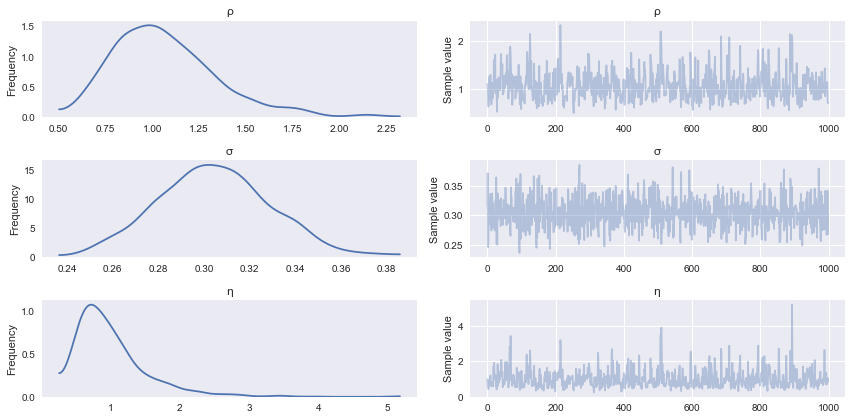

In [46]:
pm.traceplot(trace[-1000:], varnames=['ρ', 'σ', 'η']);

In addition to fitting the model, we would like to be able to generate predictions. This implies sampling from the posterior predictive distribution, which if you recall is just some linear algebra:

$$\begin{aligned}
m^*(x^*) &= k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}y \\
k^*(x^*) &= k(x^*,x^*)+\sigma^2 - k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}k(x^*,x)
\end{aligned}$$

PyMC3 allows for predictive sampling after the model is fit, using the recorded values of the model parameters to generate samples. The `sample_gp` function implements the predictive GP above, called with the sample trace, the GP variable and a grid of points over which to generate realizations:

In [47]:
Z = np.linspace(-6, 6, 100).reshape(-1, 1)
with gp_fit:
    gp_samples = pm.gp.sample_gp(trace[1000:], y_obs, Z, samples=50)

100%|██████████| 50/50 [00:02<00:00, 18.00it/s]


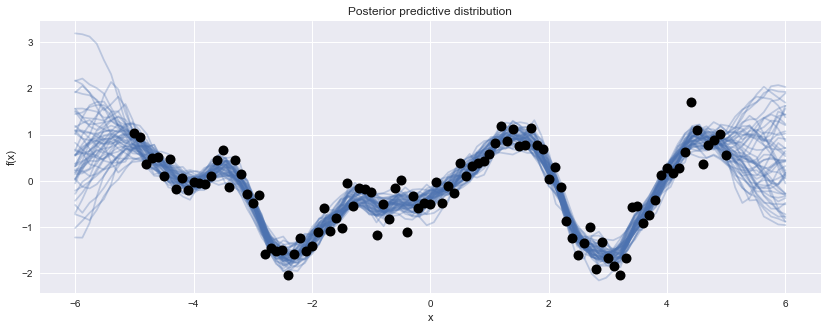

In [48]:
fig, ax = plt.subplots(figsize=(14,5))

[ax.plot(Z, x, color=line.get_color(), alpha=0.3) for x in gp_samples]
# overlay the observed data
ax.plot(X, y, 'o', color="k", ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");
ax.set_title("Posterior predictive distribution");

For models being fit to very large datasets, one often finds MCMC fitting to work too slowly, as the log-probability of the model needs to be evaluated at every iteration of the sampling algorithm. In these situations, it may be worth using variational inference methods, which replace the true posterior with a simpler approximation, and use optimization to parameterize the approximation so that it is as close as possible to the target distribution. Thus, the posterior is only an approximation, and sometimes an unacceptably coarse one, but is a viable alternative for many problems. Newer variational inference algorithms are emerging that improve the quality of the approximation, and these will eventually find their way into software. In the meantime, [Variational Gaussian Approximation](http://www.mitpressjournals.org/doi/abs/10.1162/neco.2008.08-07-592#.WKNwR9aZOu4) and [Automatic Differentiation Variational Inference](https://arxiv.org/abs/1603.00788) are available now in GPflow and PyMC3, respectively.

## Conclusions

Python users are incredibly lucky to have so many options for constructing and fitting non-parametric regression and classification models. I've demonstrated the simplicity with which a GP model can be fit to continuous-valued data using `scikit-learn`, and how to extend such models to more general forms and more sophisticated fitting algorithms using either GPflow or PyMC3. Given the prevalence of non-linear relationships among variables in so many settings, Gaussian processes should be present in any applied statistician's toolkit. I often find myself, rather than building stand-alone GP models, including them as components in a larger hierararchical model, in order to adequately account for non-linear confounding variables such as age effects in biostatistical applications, or for function approximation in reinforcement learning tasks.

This post is far from a complete survey of software tools for fitting Gaussian processes in Python. I chose these three because of my own familiarity with them, and because they occupy different sweet spots in the tradeoff between automation and flexibility. You can readily implement such models using GPy, [Stan](http://mc-stan.org), [Edward](http://edwardlib.org) and [George](https://github.com/dfm/george), to name just a few of the more popular packages. I encourage you to try a few of them to get an idea of which fits in to your data science workflow best. 